# Comparaison de performances sur un cas de recherche de mot unique dans un signal (float32 et complex64)

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numba
from numba import jit, njit, prange, complex128, float64, int64, complex64, float32
from numba import cuda
import cupy as cp

In [2]:
import os
os.environ['PYFFTW_NUM_THREADS'] = '-1' # use CPU count
import pyfftw

## Paramétrage et créations du mot unique et du signal

In [3]:
Fs = 1e6
f0 = -47e3
nrUW = 32
nrSamples = 2**20
nrDisplay = 2**14
snr = 10.0

In [4]:
np.random.seed(1973)

In [5]:
mapper_qpsk = lambda data: np.exp(1j * np.pi * (data/2 + 1/4))

In [6]:
dataUW = np.random.randint(4, size=(nrUW,))
symbolsUW = mapper_qpsk(dataUW)

In [7]:
dataAll = np.random.randint(4, size=(nrSamples,))
symbolsAll = mapper_qpsk(dataAll)

In [8]:
idxStartUW = np.random.randint(0, nrSamples - nrUW)
symbolsAll[idxStartUW:(idxStartUW + nrUW)] = symbolsUW[:]

In [9]:
sigma = 10**(-snr/20)
noise = np.random.normal(size=(nrSamples,)) + 1j * np.random.normal(size=(nrSamples,))
signalBaseband = symbolsAll + sigma * noise

In [10]:
symbolsUW = symbolsUW.astype(np.complex64)
signalBaseband = signalBaseband.astype(np.complex64)

In [11]:
def display_constellation(signal, color='r', title='Constellation'):
    plt.figure()
    plt.scatter(np.real(signal[:nrDisplay]), np.imag(signal[:nrDisplay]), s=30, c=color, alpha=0.1, edgecolors='none')
    plt.grid()
    plt.axis('equal')
    plt.xlabel('I')
    plt.ylabel('Q')
    plt.title(title)
    plt.show()

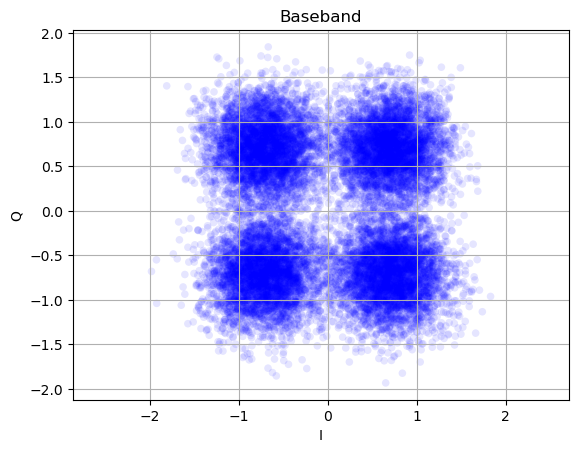

In [12]:
display_constellation(signalBaseband, 'b', 'Baseband')

### Génération d'un décalage en fréquence sur le signal
(juste pour test du gain apporté par Numba pour la génération de l'OL)

In [13]:
def create_ol(df, Fs, nr):
    phi = 0
    ol = np.empty((nr,), dtype=np.complex64)
    for k in range(nr):
        ol[k] = np.exp(1j * phi)
        phi = np.mod(phi + 2 * np.pi * df / Fs, 2 * np.pi)
    return ol

In [14]:
%timeit ol = create_ol(f0, Fs, nrSamples)

1.44 s ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
ol = create_ol(f0, Fs, nrSamples)
signal = signalBaseband * ol

In [16]:
@njit(['complex64[:](float32,float32,int64)'])
def create_ol_jit(df, Fs, nr):
    phi = 0
    ol = np.empty((nr,), dtype=np.complex64)
    for k in range(nr):
        ol[k] = np.exp(1j * phi)
        phi = np.mod(phi + 2 * np.pi * df / Fs, 2 * np.pi)
    return ol

In [17]:
%timeit ol = create_ol_jit(f0, Fs, nrSamples)

16.7 ms ± 6.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
ol = create_ol_jit(f0, Fs, nrSamples)
signal = signalBaseband * ol

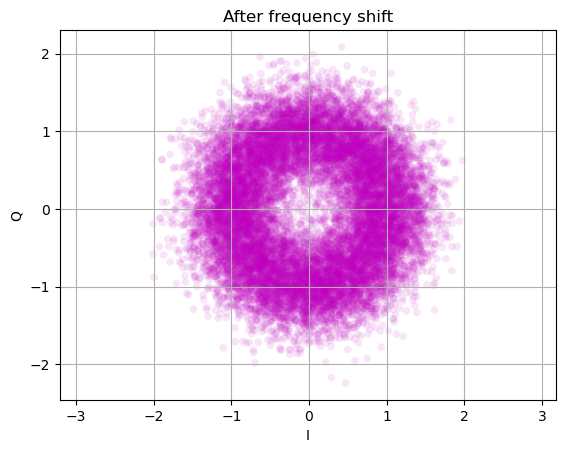

In [19]:
display_constellation(signal, 'm', 'After frequency shift')

## Recherche par méthode naïve en Python pur

In [20]:
def find_uw(s, uw):
    nr = len(s)
    nrUW = len(uw)
    cMax = 0
    idxMax = 0
    for k in range(nr - nrUW + 1):
        cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        if cAbs > cMax:
            cMax = cAbs
            idxMax = k
    return idxMax, cMax

In [21]:
%timeit idxFound, cMaxFound = find_uw(signalBaseband, symbolsUW)

3.4 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
idxFound, cMaxFound = find_uw(signalBaseband, symbolsUW)

In [23]:
print("position du motif trouvée à : ", idxFound)
print("position réelle du motif : ", idxStartUW)

position du motif trouvée à :  185443
position réelle du motif :  185443


In [24]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Numba

In [25]:
#@njit(['Tuple((int64,float32))(complex64[:],complex64[:])'])
@njit
def find_uw_jit(s, uw):
    nr = len(s)
    nrUW = len(uw)
    
    cMax = 0
    idxMax = 0
    
    for k in range(nr - nrUW + 1):
        cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        if cAbs > cMax:
            cMax = cAbs
            idxMax = k
    
    return idxMax, cMax

In [26]:
#@njit(['Tuple((int64,float32))(complex64[:],complex64[:])'])
@njit(fastmath=True)
def find_uw_jit(s, uw):
    nr = len(s)
    nrUW = len(uw)
    
    cMax = np.float32(0)
    idxMax = np.int64(0)
    
    for k in range(nr - nrUW + 1):
        su = np.complex64(0)
        idx = np.int64(k)
        for l in range(nrUW):
            su += s[idx] * np.conj(uw[l])
            idx += 1
        cAbs = np.abs(su)
        if cAbs > cMax:
            cMax = cAbs
            idxMax = k
    
    return idxMax, cMax

In [27]:
%timeit idxFound, cMaxFound = find_uw_jit(signalBaseband, symbolsUW)

19.3 ms ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
idxFound, cMaxFound = find_uw_jit(signalBaseband, symbolsUW)

In [29]:
print("position du motif trouvée à : ", idxFound)

position du motif trouvée à :  185443


In [30]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Numba parallélisé

In [31]:
numba.get_num_threads()

16

In [32]:
#@njit(['Tuple((int64,float32))(complex64[:],complex64[:])'], parallel=True)
@njit(parallel=True, fastmath=True)
def find_uw_jit_parallel(s, uw):
    nr = len(s)
    nrUW = len(uw)
    nrThreads = numba.get_num_threads()
    
    cMax = np.zeros(shape=(nrThreads,), dtype=np.float32)
    idxMax = np.zeros(shape=(nrThreads,), dtype=np.int64)
    
    for k in prange(nr - nrUW + 1):
        cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        idThread = numba.get_thread_id()
        if cAbs > cMax[idThread]:
            cMax[idThread] = cAbs
            idxMax[idThread] = k
    
    idxMaxGlobal = np.argmax(cMax)
    
    return idxMax[idxMaxGlobal], cMax[idxMaxGlobal]

In [33]:
#@njit(['Tuple((int64,float32))(complex64[:],complex64[:])'], parallel=True)
@njit(parallel=True, fastmath=True)
def find_uw_jit_parallel(s, uw):
    nr = len(s)
    nrUW = len(uw)
    nrThreads = numba.get_num_threads()
    
    cMax = np.zeros(shape=(nrThreads,), dtype=np.float32)
    idxMax = np.zeros(shape=(nrThreads,), dtype=np.int64)
    
    for k in prange(nr - nrUW + 1):
        su = np.complex64(0)
        idx = np.int64(k)
        for l in range(nrUW):
            su += s[idx] * np.conj(uw[l])
            idx += 1
        cAbs = np.abs(su)
        idThread = numba.get_thread_id()
        if cAbs > cMax[idThread]:
            cMax[idThread] = cAbs
            idxMax[idThread] = k
    
    idxMaxGlobal = np.argmax(cMax)
    
    return idxMax[idxMaxGlobal], cMax[idxMaxGlobal]

In [34]:
%timeit idxFound, cMaxFound = find_uw_jit_parallel(signalBaseband, symbolsUW)

4.02 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
idxFound, cMaxFound = find_uw_jit_parallel(signalBaseband, symbolsUW)

In [36]:
print("position du motif trouvée à : ", idxFound)

position du motif trouvée à :  185443


In [37]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Cython

In [38]:
%load_ext Cython

In [39]:
%%cython
# %%cython -a pour avoir des annotations sur les lignes de code pour mettre en évidence les appels à Python (ralentissements)
#import numpy as np
cimport numpy as np
cimport cython

#np.import_array()

@cython.boundscheck(False)
@cython.wraparound(False)
#def find_uw_cython(np.ndarray[np.complex64_t, ndim=1] s, np.ndarray[np.complex64_t, ndim=1] uw):
#def find_uw_cython(np.ndarray[float complex, ndim=1] s, np.ndarray[float complex, ndim=1] uw):
#def find_uw_cython(np.ndarray[float complex, ndim=1] s, np.ndarray[float complex, ndim=1] uw):
#def find_uw_cython(np.ndarray[float complex] s, np.ndarray[float complex] uw):
def find_uw_cython(float complex[::1] s, float complex[::1] uw):
    cdef long nr = s.shape[0]
    cdef long nrUW = uw.shape[0]
    
    cdef float cMax = 0
    cdef long idxMax = 0
    
    cdef long k, l, idx
    cdef float complex su
    cdef float cAbs
    
    for k in range(nr - nrUW + 1):
        su = 0
        idx = k
        for l in range(nrUW):
            su += s[idx] * uw[l].conjugate()
            idx += 1
        cAbs = abs(su)
        #cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        if cAbs > cMax:
            cMax = cAbs
            idxMax = k
    
    return idxMax, cMax

In [40]:
%timeit idxFound, cMaxFound = find_uw_cython(signalBaseband, symbolsUW)

40.7 ms ± 27 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
idxFound, cMaxFound = find_uw_cython(signalBaseband, symbolsUW)

In [42]:
print("position du motif trouvée à : ", idxFound)

position du motif trouvée à :  185443


In [43]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Cython parallélisé

In [44]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [45]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel cimport prange, threadid
#from openmp cimport omp_get_num_threads
#from cython.cimports.openmp import omp_set_dynamic, omp_get_num_threads

#np.import_array()

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float complex mac_cplx(float complex[::1] x, float complex[::1] y) nogil:
    cdef float complex s = 0
    cdef long l
    for l in range(len(x)):
        s += x[l] * y[l].conjugate()
    return s
   
@cython.boundscheck(False)
@cython.wraparound(False)
#def find_uw_cython(np.ndarray[np.complex64_t, ndim=1] s, np.ndarray[np.complex64_t, ndim=1] uw):
#def find_uw_cython(np.ndarray[float complex, ndim=1] s, np.ndarray[float complex, ndim=1] uw):
#def find_uw_cython(np.ndarray[float complex, ndim=1] s, np.ndarray[float complex, ndim=1] uw):
#def find_uw_cython(np.ndarray[float complex] s, np.ndarray[float complex] uw):
def find_uw_cython_parallel(float complex[::1] s, float complex[::1] uw, nrThreads=16):
    cdef long nr = s.shape[0]
    cdef long nrUW = uw.shape[0]
    
    #cdef float[:] cMax = np.zeros(omp_get_num_threads(), dtype=np.float32)
    #cdef long[:] idxMax = np.zeros(omp_get_num_threads(), dtype=np.int64)
    cdef float[:] cMax = np.zeros(nrThreads, dtype=np.float32)
    cdef long[:] idxMax = np.zeros(nrThreads, dtype=np.int64)
    
    cdef long k, l, idx
    #cdef float complex su
    cdef float cAbs
    
    #for k in range(nr - nrUW + 1):
    for k in prange(nr - nrUW + 1, nogil=True):
        #su = 0
        #idx = k
        #for l in range(nrUW):
        #    su += s[idx] * uw[l].conjugate()
        #    idx += 1
        #cAbs = abs(su)
        cAbs = abs(mac_cplx(s[k:k + nrUW], uw))
        #cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        if cAbs > cMax[threadid()]:
            cMax[threadid()] = cAbs
            idxMax[threadid()] = k
    
    cdef int im = np.argmax(cMax)
    return idxMax[im], cMax[im]

In [46]:
%timeit idxFound, cMaxFound = find_uw_cython_parallel(signalBaseband, symbolsUW)

94.8 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### A investiguer !
Ce temps beaucoup plus long que la version à 1 seul process indique un pb de conception du code.
TODO: rechercher une solution offrant un gain de performance...

In [47]:
idxFound, cMaxFound = find_uw_cython_parallel(signalBaseband, symbolsUW)

In [48]:
print("position du motif trouvée à : ", idxFound)

position du motif trouvée à :  185443


In [49]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Numba pour Cuda (kernel)

In [50]:
@cuda.jit('void(complex64[:],complex64[:],float32[:])')
def find_uw_cuda_jit(s, uw, cAbs):
    nr = len(s)
    nrUW = len(uw)
    idx = cuda.grid(1)
    if idx < (nr - nrUW + 1):
        sUw = 0
        for k in range(nrUW):
            sUw += s[idx + k] * uw[k].conjugate()
        cAbs[idx] = abs(sUw)

In [51]:
%%timeit
sBbCu = cuda.to_device(signalBaseband)
uwCu = cuda.to_device(symbolsUW)
cAbsCu = cuda.device_array((nrSamples - nrUW + 1,), dtype=np.float32)
find_uw_cuda_jit.forall(len(cAbsCu))(sBbCu, uwCu, cAbsCu)
# switch to Cupy library to apply the argmax reduction
cAbsCp = cp.asarray(cAbsCu)
idxFoundCp = cp.argmax(cAbsCp)
cMaxFoundCp = cAbsCp[idxFoundCp]
idxFound = idxFoundCp.item()
cMaxFound = cMaxFoundCp.item()

2.43 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
sBbCu = cuda.to_device(signalBaseband)
uwCu = cuda.to_device(symbolsUW)
cAbsCu = cuda.device_array((nrSamples - nrUW + 1,), dtype=np.float64)
find_uw_cuda_jit.forall(len(cAbsCu))(sBbCu, uwCu, cAbsCu)
# switch to Cupy library to apply the argmax reduction
cAbsCp = cp.asarray(cAbsCu)
idxFoundCp = cp.argmax(cAbsCp)
cMaxFoundCp = cAbsCp[idxFoundCp]
idxFound = idxFoundCp.item()
cMaxFound = cMaxFoundCp.item()

In [53]:
# to switch back to Numba Cuda
# xCu = cuda.as_cuda_array(cAbsCp)

In [54]:
idxFound

185443

## Recherche utilisant une corrélation globale utilisant la FFT de Numpy

In [55]:
def find_uw_fft(s, uw):
    nr = len(s)
    nrUW = len(uw)
    sF = np.fft.fft(s)
    uwL = np.zeros_like(sF)
    uwL[:nrUW] = uw
    uwLF = np.fft.fft(uwL)
    cAbs = np.abs(np.fft.ifft(sF * np.conj(uwLF)))
    idxMax = np.argmax(cAbs)
    cMax = cAbs[idxMax]
    return idxMax, cMax

In [56]:
%timeit idxFound, cMaxFound = find_uw_fft(signalBaseband, symbolsUW)

87.2 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
idxFound, cMaxFound = find_uw_fft(signalBaseband, symbolsUW)

In [58]:
print("position du motif trouvée par FFT à : ", idxFound)

position du motif trouvée par FFT à :  185443


In [59]:
assert(idxFound == idxStartUW)

## Recherche utilisant une corrélation globale utilisant la FFT de pyFFTW

In [60]:
pyfftw.config.NUM_THREADS

16

In [61]:
def find_uw_fftw(s, uw):
    nr = len(s)
    nrUW = len(uw)
    sFFTW = pyfftw.empty_aligned((nrSamples,), dtype=np.complex64)
    sFFTW[:] = s
    uwLFFTW = pyfftw.zeros_aligned((nrSamples,), dtype=np.complex64)
    uwLFFTW[:nrUW] = uw
    sF = pyfftw.interfaces.numpy_fft.fft(sFFTW)
    uwLF = pyfftw.interfaces.numpy_fft.fft(uwLFFTW)
    cAbs = np.abs(pyfftw.interfaces.numpy_fft.ifft(sF * np.conj(uwLF)))
    idxMax = np.argmax(cAbs)
    cMax = cAbs[idxMax]
    return idxMax, cMax

In [62]:
%timeit idxFound, cMaxFound = find_uw_fftw(signalBaseband, symbolsUW)

32.6 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [63]:
idxFound, cMaxFound = find_uw_fftw(signalBaseband, symbolsUW)

In [64]:
print("position du motif trouvée par FFT à : ", idxFound)

position du motif trouvée par FFT à :  185443


In [65]:
assert(idxFound == idxStartUW)

## Recherche utilisant une corrélation globale par FFT sur GPU à l'aide de Cupy

In [66]:
def find_uw_fft_gpu(s, uw):
    nr = len(s)
    nrUW = len(uw)
    sGpu = cp.asarray(s)
    sF = cp.fft.fft(sGpu)
    uwLGpu = cp.zeros_like(sF)
    uwLGpu[:nrUW] = cp.asarray(uw)
    uwLF = cp.fft.fft(uwLGpu)
    cAbs = cp.abs(cp.fft.ifft(sF * cp.conj(uwLF)))
    idxMax = cp.argmax(cAbs)
    cMax = cAbs[idxMax]
    return idxMax.item(), cMax.item()

In [67]:
%timeit idxFound, cMaxFound = find_uw_fft_gpu(signalBaseband, symbolsUW)

1.66 ms ± 5.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [68]:
idxFound, cMaxFound = find_uw_fft_gpu(signalBaseband, symbolsUW)

In [69]:
assert(idxFound == idxStartUW)